### Experiments
    - Test if small batch is better
        - Exp 1
            - Save to 006
            - starting from 005, and shring batch size to 512
            - Results: after 183 epochs, the accuracy was actually lower than before training. 
              Batch size is probably not to big at 4096.
        - Exp 2
            - Starting from 012, a 100.000 pm net trained for 1600 epochs at bs 4096
            - Switching to bs 32 created horrible results, network totally failed to perform, lost acc from 
              0.95 to 0.85 in 17 epochs. Plus, super slow to train
                 
    - Test Adam
        - Results
            - 007 Adam, final accuracy 0.939 after 500
            - 005 Adadelta, final accuracy 0.952 after 1000 epochs
            - Adam not performing better than Adadelta
            
    - Test 2x2 and 3x3 filters for performance
        - 2x2 5 layers (005)
        - 3x3 3 layers (003)
        - ~50.000 parameters
        - Results
            - 005 vs 008
            - Same performance after 331 epochs
            
    - Test float16
        - 005 float32
        - 010 float16
        - Results
            - float16 scored lower
            - float16 is 40% longer per epoch (35sec vs 50sec per epoch
            - float32 is the way to go!
            
    - Try Batch Normalization
        - model.add(BatchNormalization())
        - Results:
            - Comparing with 005, no batch norm
            - Saved to 011, with batch norm
            - ~same number of weights...
            - Batch Normalization is performing worse after ~40 epochs
            
    - Try different initial weights
        - keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
        - Results
            - Tried for a few epochs, similar curve as for 005
            
    - Test different size model
        - Experiments
            - 005
                - 50kpm
                - 500 epochs
                - 0.952 acc
                - still learning
                - 2048bs > 37s/epoch
                - 4096bs > 29s/epoch
            - 013
                - 188kpm
                - 350 epochs
                - 0.968 acc
                - 150-200 epochs > stalled
                - 0.968 after 350 epochs
                - 6 hours
            - 014
                - 388kpm
                - epochs
                - 0.974 after 243 epochs
            - xxx not saved
                - 500kpm
                - 143 epochs
                - 0.972
                - slightly worse performance than 014, possibly slower to converge, but taking to long to train
            - 016
                - 10kpm
                - 500 epochs
                - 0.91 acc
            - 01
                - 
        - Results
            - 014 is best, 005 probably good enough
            - 017 is best for fast training, maybe?
            
    - Measure kpm and batch size effect on calc speed
        - not much difference
            - #016:0.913  10kpm 2048:30                  8192:23:38% 32768:17:52% 
            - #005:0.952  50kpm 2048:37s    4096:28:50% 
                - 0.94 after 100epoch = 3000s ~ 1 hour 
            - #013:0.968 188kpm 2048:50s    4096:40s:61%             32768:46s:80% 65536:42s:99% 
                - 0.96 after 50 epoch = 41m
            - #014:0.974 388kpm 2048:3m:91%
                - 0.97 after 60 epoch =180m
            
    - Test effect of bigger batch size
        - Faster calculations, but much worse performance
            - see 017 and 018
            
    - Try smaller batch size
        - source 014
            - 2048 batch size
        - dest
            - 256 bs
        -Results
            - started to forget, 
            
     - Test if increased training after validation lággildi is doing any good
         - 022 = 388 kpm
         - Laggildi at 70 epochs, accuracy 0.970
         - Trained up to 250 epochs, accuracy 0.972
         - Results
             - it's no use to train after the 70 epoch mark
     
    - count wdl histogram
    
    - Do transfer learning
         - Decide whats the best net
            - 188kpm from #013, stalled at 60 epoch 4pc. 41m for 60 epochs.
                - 2x32-2x64-2x128-2x160-2x256
         - Train on 3pc
             - 024:0.998
         - Transfer to 4pc
             - 029: 0.964
         - Train 4pc from scratch
             - 028: 0.966
         
         
         - How to transfer only n layers?
         - How to freeze layers?
         - Do n-transfer with and without freeze
             - Use average of m runs (add average later...)
     
    - Find best CNN layer number
        - trained for 250 ep
            - 3 layers
                - 030
                - final 0.922 
            - 4 layers
                - 032
                - final 0.951
            - 5 layers
                - 028
                - final 0.966
            - 6 layers
                - 034
                - 16 32 64 128 128 128
                - final 0.975
            - 6 layers
                - 035
                - 16 64 64 96 128 128
                - final 0.975
            - 7 layers
                - 03
               ...
        - measure time to train on these nets, and decide on structure based on that
        
        
          
                
            - 
     
     
     
     
    ---------- TODO NOW --------------------------------------------------     
    
    
    
    
    
    - performance of 4pc seems to be negatively affected by transfer from 3pc
        - test if I'm overfitting on 3pc, by transfering after n epochs of 3pc training
            with n = 10, 20, 30, ...
    
    
    


    ---------- TODO NEXT --------------------------------------------------
    
     - Test if increased training after validation lággildi is doing any good
         - Same test as above, but with smaller net (188 kpm which is MUCH faster to train)
             - Train both with early stopping and without, and see where it stops
                 - keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0,
                   patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=False)

            




    ---------- TODO SOMETIME --------------------------------------------------
    
    - Do tree fold testing on 014, and focus on lággildi in loss at 50epochs
    
    - Transfer learning
        - Read article again
        - Make function for measurements
            - Copy on n first layers
            - freeze layers
            - Average
           



    - Test Checkpoints feature
    
    - Three fold splitting
        - model.fit(X, Y, validation_split=0.33, epochs=150, batch_size=10)
        - https://stackoverflow.com/questions/38250710/how-to-split-data-into-3-sets-train-validation-and-test
        
    - cross validation
        - https://machinelearningmastery.com/evaluate-performance-deep-learning-models-keras/
        
    - Train longer....

    - Try opther optimizers

    - Make histogram of WDL values
    
    - Do TL experiment
        - Take into account data split effect on TL (split 4pc at x, and then transfer to 5pc)
        - Three split data, training, validation and testing
        - Results
        
    - Finish 5pc dataset




# WDL score count
#### 3ps only legal
WDLhistogram {-2=0, -1=0, 0=38368, 1=0, 2=124960}
#### 4pc only legal
WDLhistogram {-2=1737970, -1=0, 0=2485090, 1=0, 2=3213028}

# Randomly guess right probabilites
Purpose: When training net $N$ on $n$ piece dataset and using it to guess labels for a $m$ piece dataset, what is the expected accuracy of $N$ on the $m$ piece dataset? 

Methood: Given the approximation that net $N$ outputs labels randomly with probabilities $p_n$, and we sample from the $m$ piece dataset with label probabilites $p_m$, then the probability of guessing right is given by

$$ P_{n>m} = \sum_{i=-1}^1 p_n(i) * p_m(i)$$

Results: Using calcRandomPerfProbability.py we get

$$P_{3>4} = 0.409$$





In [1]:
### TRAINING TEMPLATE CODE

# ##############################
# #    PARAMETERS 
# ##############################
# import math

# # What data to use
# tableBase = '4PpKk'
# convertStates = False
# fractionOfDataToUse = 0.01 # [0,1]

# # Interactive
# askForConfirmation = True
# # Transfer Learning
# loadWeights = True 
# weightsSource = '024'

# # Compare with other result during training
# compareResultsDuringTraining = False
# compareWith = '013' # orginal net structure, trained from random on 4pc dataset


# # NN parameters
# # filters = [8,16,16,32,32]    #016:0.913  10kpm 2048:30                  8192:23:38% 32768:17:52% 
# # filters = [8,16,32,64,128]   #005:0.952  50kpm 2048:37s    4096:28:50% 
# filters = [8,32,64,128,256]  #013:0.968 188kpm 2048:50s    4096:40s:61%             32768:46s:80% 65536:42s:99% 
# # filters = [32,64,128,160,256]#014:0.974 388kpm 2048:3m:91% 
# filterShape = [2,2,2,2,2]
# batch_size = 2048
# epochs = 30
# multiGPU = False
# whichGPU = 0
# # optimizer = 'Adam'
# optimizer = 'Adadelta'
# useBatchNorm = False




# ### NO NEED TO MODIFY BELOW ###
# # Generate dataset variables
# fileName = tableBase + '.hdf5'
# dataSetName = tableBase + '_onlyLegal'
# if not convertStates: 
#     dataSetName = tableBase + '_onlyLegal_fullState'
# dataSetWdlName = tableBase + '_Wdl_onlyLegal'

# # Number of Pieces
# nPi =  int(dataSetName[0])
# nPa = nPi - 2
# nWPa = math.ceil(nPa/2)

# # Other NN stuff
# num_classes = 5
# input_shape = (4,8,8)

##############################
#
#    IMPORTS 
#
##############################

# ### To select which GPU to use, import these before importing Keras or Tensorflow
# import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# # The GPU id to use, usually either &quot;0&quot; or &quot;1&quot;
# os.environ["CUDA_VISIBLE_DEVICES"]="0"  
 
# # Do other imports now...

import os
    
from matplotlib import pyplot as plt
from IPython.display import clear_output

# from __future__ import print_function
import keras
# from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation
from keras import backend as K
# import pandas as pd
from sklearn.model_selection import train_test_split
import sys
import h5py
import numpy as np
import pickle

#Tensorboard
# from time import time
import time
from tensorflow.python.keras.callbacks import TensorBoard

# Weight Checkpoints
from keras.callbacks import ModelCheckpoint

# Move directories
import shutil

##############################
#
#    Plot Losses Callback
#
##############################

class PlotLosses(keras.callbacks.Callback):
    
    def on_train_begin(self, logs={}):
        # Reshape input vector to fit on graph
        def reshapeVector(vec):
            l = len(vec)
            L = epochs - l
            if L>=0:
                tail = np.ones((L), dtype = int) * vec[-1]
                vec = np.hstack((vec,tail))
            return vec
                
        
        # Load data to compare with 
        if compareResultsDuringTraining:
            self.compareData = load_obj('Results/' + compareWith, 'fitHistory')
            self.compAcc = reshapeVector(self.compareData['acc'])
            self.compValAcc = reshapeVector(self.compareData['val_acc'])
            self.compLoss = reshapeVector(self.compareData['loss'])
            self.compValLoss = reshapeVector(self.compareData['val_loss'])
        
        self.i = 0
        self.x = []
        self.loss = []
        self.val_loss = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        self.logs = {'acc':[], 'val_acc':[], 'loss':[], 'val_loss':[]}
        self.saveDir = 'Results/' + str(resID) + '/fitTemp/'

    def on_epoch_end(self, epoch, logs={}):
        
        self.x.append(self.i)
        self.loss.append(logs['loss'])
        self.val_loss.append(logs['val_loss'])
        self.acc.append(logs['acc'])
        self.val_acc.append(logs['val_acc'])
        self.logs = {'acc':self.acc, 'val_acc':self.val_acc, 'loss':self.loss, 'val_loss':self.val_loss}
        self.i += 1
        
        clear_output(wait=True)
    
        # Create plots
        f = plt.figure(figsize=(15,7))
        ax = f.add_subplot(121)
        ax2 = f.add_subplot(122)
        
        
        # Plot Loss 
        ax.plot(self.x, self.loss, color='blue', label="Train", linewidth = 1)
        ax.plot(self.x, self.val_loss, color='deepskyblue', label="Validation", linewidth = 1)
        if compareResultsDuringTraining:
            ax.plot(self.x, self.compLoss[:len(self.loss)], color='black', label=compareWith + " Training", linewidth = 1)
            ax.plot(self.x, self.compValLoss[:len(self.loss)], color='gray', label=compareWith + " Validation", linewidth = 1)
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Loss')
        ax.legend()
        ax.set_ylim(bottom=0)
        ax.grid(True)
        
#         # Plot Accuracy
        ax2.plot(self.x, self.acc, 'b-', label="Train", linewidth = 1)
        ax2.plot(self.x, self.val_acc, color = 'deepskyblue', label="Validation", linewidth = 1)
        if compareResultsDuringTraining:
            ax2.plot(self.x, self.compAcc[:len(self.acc)], color='black', label=compareWith + " Training", linewidth = 1)
            ax2.plot(self.x, self.compValAcc[:len(self.acc)], color='silver', label=compareWith + " Validation", linewidth = 1)
        ax.set
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Accuracty')
        ax2.legend()
        ax2.set_ylim(top=1)
        ax2.grid(True)
        
        # Show and save plot
# #         plt.tight_layout()
        plt.savefig(self.saveDir + 'currentAccAndLoss')
        plt.show();

#         # Plot Loss
#         plt.subplot(1,2,1)
#         plt.figure(figsize=(8,8))
#         plt.plot(self.x, self.loss, 'b-', label="Train", linewidth = 1)
#         plt.plot(self.x, self.val_loss, 'r-', label="Validation", linewidth = 1)
#         plt.plot(self.x, self.compLoss[:len(self.loss)], 'b--', label=compareWith + " Training")
#         plt.plot(self.x, self.compValLoss[:len(self.loss)], 'r--', label=compareWith + " Validation")
#         plt.xlabel('Epochs')
#         plt.ylabel('Loss')
#         plt.legend()
#         plt.ylim(bottom=0)
#         plt.grid(True)
# #         plt.savefig('fitTemp/currentLoss')
# #         plt.show();
        
#         # Plot Accuracy
#         plt.subplot(1,2,2)
#         plt.figure(figsize=(8,8))
#         plt.plot(self.x, self.acc, 'b-', label="Train", linewidth = 1)
#         plt.plot(self.x, self.val_acc, 'r-', label="Validation", linewidth = 1)
#         plt.plot(self.x, self.compAcc[:len(self.acc)], 'b--', label=compareWith + " Training")
#         plt.plot(self.x, self.compValAcc[:len(self.acc)], 'r--', label=compareWith + " Validation")
#         plt.xlabel('Epochs')
#         plt.ylabel('Accuracty')
#         plt.legend()
#         plt.ylim(top=1)
#         plt.grid(True)
        
#         # Show and save plot
# #         plt.tight_layout()
# #         plt.savefig('fitTemp/currentAccAndLoss')
#         plt.show();
        
        print("Train Accuracy of last epoch: ", logs['acc'])
        print("Validation Accuracy of last epoch: ", logs['val_acc'])
        print("Train Loss of last epoch: ", logs['loss'])
        print("Validation Loss of last epoch: ", logs['val_loss'])
        
        with open(self.saveDir + 'logs.txt','w') as file:
            file.write(str(self.logs))
            
        with open(self.saveDir + 'atEpochNr.txt','w') as file:
            file.write(str(epoch))
        
plot_losses = PlotLosses()

##############################
#
#    Misc Functions
#
##############################
 
def copyDirectory(src, dest):
    try:
        shutil.copytree(src, dest)
    # Directories are the same
    except shutil.Error as e:
        print('Directory not copied. Error: %s' % e)
    # Any error saying that the directory doesn't exist
    except OSError as e:
        print('Directory not copied. Error: %s' % e)
        
def askAbortIfPathExists(fileName): 
    if askForConfirmation:
        if os.path.exists(fileName):
            a = input("Error, file/directory {} exists, continue? [y/n]".format(fileName))
            if a[0] != "y" and a[0] != "Y":
                sys.exit()
            
def createDir(dir, confirm = True):
    if os.path.exists(dir):
        askAbortIfPathExists(dir) 
    else:
        os.makedirs(dir)
        
def save_obj(saveDir, saveName, obj ):
    if not os.path.exists(saveDir):
        os.makedirs(saveDir)
    fileName = saveDir + '/'+ saveName + '.pkl'
    askAbortIfPathExists(fileName)
    with open(fileName, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(dir, fileName ):
    with open(dir + '/' + fileName + '.pkl', 'rb') as f:
        return pickle.load(f)
    
def sq2hnit(sq):
    col = sq%8
    row = (sq - col)//8
    return col,row

# 0: pawns
# 1: kings
def vecSt2fullSt(vecSt, nPi, nPa, nWPa):
    fullSt = np.zeros((4,8,8), dtype = 'bool')
    for i in range(nPi - 2):
        sq = vecSt[i]
        col,row = sq2hnit(sq)
        if i < nWPa:
            fullSt[0][row][col] = True
        else:
            fullSt[1][row][col] = True
    col,row = sq2hnit(vecSt[-2])
    fullSt[2][row][col] = True
    col,row = sq2hnit(vecSt[-1])
    fullSt[3][row][col] = True
    return fullSt 

def vecSt2fullSt_8x8x2(vecSt, nPi, nPa, nWPa):
    fullSt = np.zeros((8,8,2), dtype = 'int8')
    for i in range(nPi - 2):
        sq = vecSt[i]
        col,row = sq2hnit(sq)
        if i < nWPa:
            fullSt[row][col][0] = 1
        else:
            fullSt[row][col][0] = -1
    col,row = sq2hnit(vecSt[-2])
    fullSt[row][col][1] = 1
    col,row = sq2hnit(vecSt[-1])
    fullSt[row][col][1] = -1
    return fullSt 

# count nr of each score instance
# wdlCounter placeholders: [-2, -1, 0, 1 ,2]

def wdlCountingMachine(ds):
    wdlCounter = [0,0,0,0,0]
    l = len(ds)
    i = 0
    intv = l//100
    for wdl in ds:
        i += 1
        if i%intv == 0:
            sys.stdout.write(str((i*100)//l) + " percentage")
            sys.stdout.write('\r')
            sys.stdout.flush()
        wdlCounter[wdl[0] + 2] += 1
    print(wdlCounter)
    return wdlCounter
# wdlCountingMachine(d3t)

##############################
#
#    LOAD DATA
#
##############################
# load datasets
def loadData(randomState = 42):
    with h5py.File(fileName, 'r') as f:
        d = f[dataSetName]
        dt = f[dataSetWdlName]
        l = len(d)
        loadLength = int(l * fractionOfDataToUse)

        if convertStates:
            X = np.array([vecSt2fullSt(vecSt,nPi, nPa, nWPa) for vecSt in d[:loadLength]])
        else:
            X = d[:loadLength]
        y = dt[:loadLength]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=randomState)

    del X
    del y

    print('X_train shape:', X_train.shape)
    print('y_train shape:', y_train.shape)
    print('X_test shape:', X_test.shape)
    print('y_test shape:', y_test.shape)
    print(X_train.shape[0], 'train samples')
    print(X_test.shape[0], 'test samples')


    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    print("Done loading dataset")
    return X_train, X_test, y_train, y_test


##############################
#
#    CREATE MODEL
#
##############################
def createModel():
    # import keras.backend as K
    # K.set_floatx('float16')
    # K.set_epsilon(1e-4) #default is 1e-7
    # K.set_floatx('float32')
    # K.set_epsilon(1e-7) #default is 1e-7

    model = Sequential()
    
    nnStr = ''
    for i in range(len(filters)):
        s = str(filterShape[i])
        filter = str(filters[i])
        nnStr += s + 'x' + filter + '-'
    nnStr = nnStr[:-1]

    assert (len(filters) == len(filterShape)),"Error, len(filters) != len(filterShape)"
    if useBatchNorm:
        for i in range(len(filters)):
            if i  == 0:
                model.add(Conv2D(filters[i], kernel_size=(filterShape[i], filterShape[i]),
                                 padding='valid',
                                 data_format = "channels_first",
                                 use_bias = False,
                #                  kernel_initializer = 
                                 input_shape=input_shape))
            else:
                model.add(Conv2D(filters[i], kernel_size=(filterShape[i], filterShape[i]),
                                 use_bias = False,
                                 padding='valid'))
            model.add(BatchNormalization())
            model.add(Activation("relu"))
    else:
        for i in range(len(filters)):
            if i  == 0:
                model.add(Conv2D(filters[i], kernel_size=(filterShape[i], filterShape[i]),
                                 padding='valid',
                                 activation='relu',
                                 data_format = "channels_first",
    #                              kernel_initializer = keras.initializers.RandomNormal(mean=0.0, stddev=1.0, seed=None),
                                 input_shape=input_shape))
            else:
                model.add(Conv2D(filters[i], kernel_size=(filterShape[i], filterShape[i]),
                                 padding='valid',
    #                              kernel_initializer = keras.initializers.RandomNormal(mean=0.0, stddev=1.0, seed=None),
                                 activation='relu'))
    model.add(Flatten())
    model.add(Dense(num_classes, activation='softmax'))
    if multiGPU: 
        model = keras.utils.multi_gpu_model(model, gpus=2)
    model.summary()
    
    if loadWeights:
        if loadCheckpointWeights:
            if weightsCheckpoint[:-5] == '.hdf5':
                weightsPath = 'Results/' + weightsSource + '/weightsCheckpoints/' + weightsCheckpoint        
            else:
                weightsPath = 'Results/' + weightsSource + '/weightsCheckpoints/' + weightsCheckpoint + '.hdf5'        
        else:
            weightsPath = 'Results/' + weightsSource + '/weights.hdf5'
        
        print("Loading weights from {}".format(weightsPath))
        model.load_weights(weightsPath)
    else:
        print("Starting with random weights")

    if optimizer == "Adadelta":
        model.compile(loss=keras.losses.categorical_crossentropy,
                      optimizer=keras.optimizers.Adadelta(),
                      metrics=['accuracy'])
    elif optimizer == 'Adam':
        model.compile(loss=keras.losses.categorical_crossentropy,
                      optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
                      metrics=['accuracy'])
    else:
        sys.exit("Error, invalid optimizer.")
        
    print("Done creating model")
    return model, nnStr

##############################
#
#    TRAIN MODEL
#
##############################
def trainModel(resID, model):
    # save weight checkpoint
    saveWeigthsPath = "Results/" + resID + '/weightsCheckpoints/'
    print("Saving weights to {}".format(saveWeigthsPath))
    createDir(saveWeigthsPath)
    filepath = saveWeigthsPath + "weights-checkp-{epoch:03d}-{val_acc:.3f}.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    
    kpm = model.count_params()//1000
    dateTime = time.strftime('%Y-%m-%d-%H:%M:%S', time.localtime())
    
    if loadWeights:
        initWeightsId = weightsSource
    else:
        initWeightsId = 'RND'
        
    logDir = './logs/{}-{}pc-{}-{}KPM-{}'.format(resID,nPi, initWeightsId, kpm, expDescr, dateTime )
    
    fitHistory = model.fit(X_train, y_train,
          batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              callbacks=[checkpoint, 
                         plot_losses, 
                         keras.callbacks.TensorBoard(log_dir=logDir\
                         )],
#                         .format(resID,nPi, initWeightsId, kpm, int(time() - 1500000000)))],
              validation_data=(X_test, y_test))
    print("Training done")
    return fitHistory, logDir

##############################
#
#    CALCULATE SCORE
#
##############################
def calcScore(model):
    print("Calculating score")
    score = model.evaluate(X_test, y_test, verbose=1)
    print('Evaluated test loss:', score[0])
    print('Evaluated test accuracy:', score[1])
    return score
#score = calcScore()

##############################
#
#    SAVE RESULTS
#
##############################
def genNextResultsDir(model, resID = None):
    if resID == None:
        #Get next resID
        with open('Results/lastResId.txt','r') as file:
            lastId = file.read()
        resID = str(int(lastId) + 1).zfill(3)

        #Iterate resID 
        with open('Results/lastResId.txt','w') as file:
            file.write(resID)
    
    # Generate save dir
    saveDir = 'Results/' + str(resID) + '/'
    print('Save dir: ' + saveDir)
    print("Creating save dir")
    createDir(saveDir, confirm = True)

    # Save info directories
    if loadWeights:
        initWeightsId = weightsSource
    else:
        initWeightsId = 'RND'
        
    kpm = str(model.count_params()//1000) + 'kpm'
        
    createDir(saveDir + '_' +  '_0.experimentDesc-------' + str(expDescr)) 
    createDir(saveDir + '_' +  '_1.numberOfPieces-------' + str(nPi)) 
    createDir(saveDir + '_' +  '_2.neuralNetStructure---' + str(nnStr))
    createDir(saveDir + '_' +  '_3.loadedWeightsFrom----' +  str(initWeightsId))
    createDir(saveDir + '_' +  '_5.batchSize------------' +  str(batch_size))
    createDir(saveDir + '_' +  '_6.optimizer------------' +  str(optimizer))
    createDir(saveDir + '_' +  '_7.nrOfparameters-------' +  str(kpm))
    createDir(saveDir + 'fitTemp')
    print("Done generating results dir {}".format(saveDir))
    return resID

def saveTrainResults(resID, model, logDir):
    print("Saving results to dir {}".format(resID))
    saveDir = 'Results/' + str(resID) + '/'
    ep = len(model.history.history['acc'])
    createDir(saveDir + '_' +  '_4.epochs---------------' +  str(ep) + '_of_' + str(epochs) )
    createDir(saveDir + '_' +  '_8.finalAccuracy--------' +  str(round(score[1],3)))
    #save history
    print("Saving history...")
    hist = model.history.history
    saveName = 'fitHistory'
    save_obj(saveDir, saveName, hist)

    #save weights
    print("Saving weights...")
    fileName = saveDir + 'weights.hdf5'
    askAbortIfPathExists(fileName)
    model.save_weights(fileName)

    #save figures
    print("Saving figures...")
    acc = hist['acc']
    loss = hist['loss']
    val_acc = hist['val_acc']
    val_loss = hist['val_loss']
    x = [i for i in range(len(acc))]

    # Create plots
    f = plt.figure(figsize=(15,7))
    ax = f.add_subplot(121)
    ax2 = f.add_subplot(122)

    # Plot Loss 
    ax.plot(x, loss, color='blue', label="Train", linewidth = 1)
    ax.plot(x, val_loss, color='deepskyblue', label="Validation", linewidth = 1)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.set_ylim(bottom=0)
    ax.grid(True)

    # Plot Accuracy
    ax2.plot(x, acc, 'b-', label="Train", linewidth = 1)
    ax2.plot(x, val_acc, color = 'deepskyblue', label="Validation", linewidth = 1)
    ax.set
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracty')
    ax2.legend()
    ax2.set_ylim(top=1)
    ax2.grid(True)

    # Save plots
    plt.savefig(saveDir + 'performance')
    plt.show();

    #save summary
    print("Saving summary...")
    from contextlib import redirect_stdout
    fileName = saveDir + 'modelsummary.txt'
    askAbortIfPathExists(fileName)
    with open(fileName, 'w') as f:
        with redirect_stdout(f):
            model.summary()
            
    # Save tensorboard logs
    print("Saving tensorboard logs...")
    saveDir = 'Results/' + str(resID) + '/' + logDir[7:]
    logDir = logDir 
    copyDirectory(logDir, saveDir)
    
    print("All done saving stuff!")

##############################
#
#    COMPARE RESULTS
#
##############################
def compareResults(res1, res2, label1 = '', label2 = '', metric1 = 'acc', metric2 = 'acc', saveFigName = '', makeEqual = False):
    # Reshape input vector to fit on graph
    def makeEqualLength(vec1, vec2):
        l1 = len(vec1)
        l2 = len(vec2)
        if l1 == l2:
             pass
        elif l1 > l2: 
            l = l1 - l2
            tail = np.ones((l), dtype = int) * vec2[-1]
            vec2 = np.hstack((vec2,tail))
        else:
            l = l2 - l1
            tail = np.ones((l), dtype = int) * vec1[-1]
            vec1 = np.hstack((vec1,tail))
        return vec1, vec2
     
    y1 = load_obj('Results/' + res1,'fitHistory')
    y2 = load_obj('Results/' + res2,'fitHistory')
    acc1 = y1[metric1]
    acc2 = y2[metric2]
    
    if makeEqual:
        acc1, acc2 = makeEqualLength(acc1, acc2)
    
    if label1 == '' :
        label1 = res1
    if label2 == '' :
        label2 = res2
        
    bottom, top = plt.ylim()  # return the current ylim
    if "acc" in metric1:
        print('plotting accuracy')
        yname = "Accuracy"
        plt.ylim(bottom = bottom, top=1)
    else:
        print('plotting loss')
        plt.ylim(bottom = 0, top=top)
        yname = "Loss"
    
    x = [i for i in range(len(acc1))]
    plt.plot(x,acc1, label = label1)
    x = [i for i in range(len(acc2))]
    plt.plot(x,acc2, label = label2)
    bottom, top = plt.ylim()  # return the current ylim
    if "acc" in metric1:
        print('plotting accuracy')
        yname = "Accuracy"
        plt.ylim(bottom = bottom, top=1)
    else:
        print('plotting loss')
        plt.ylim(bottom = 0, top=top)
        yname = "Loss"
    plt.xlabel('epochs')
    plt.ylabel(yname)
    plt.legend()
    if saveFigName != '': plt.savefig(saveFigName)
    plt.show()

#compareResults('005','011', label1='test1', label2='test2', metric1='loss', metric2='loss', saveFigName = 'testmynd', makeEqual = True)

Using TensorFlow backend.


### TRAINING TEMPLATE CODE


In [2]:
### TRAINING TEMPLATE CODE

##############################
#    PARAMETERS 
##############################
import math

# Experiment description
expDescr = "Experiment description text"

# What data to use
tableBase = '4PpKk'
convertStates = False
fractionOfDataToUse = 1 # [0,1]

# Interactive (just in general if one is asked for confirmations, set to False if on autopilot over night f.x.)
askForConfirmation = True

# Transfer Learning
loadWeights = False 
weightsSource = '024'

# Compare with other result during training
compareResultsDuringTraining = False
compareWith = '013' # orginal net structure, trained from random on 4pc dataset


# NN parameters
# filters = [8,16,16,32,32]    #016:0.913  10kpm 2048:30                  8192:23:38% 32768:17:52% 
# filters = [8,16,32,64,128]   #005:0.952  50kpm 2048:37s    4096:28:50% 
# filters = [8,32,64,128,256]  #013:0.968 188kpm 2048:50s    4096:40s:61%             32768:46s:80% 65536:42s:99% 
# filters = [32,64,128,160,256]#014:0.974 388kpm 2048:3m:91% 
filters = [16,32,64,128,128,128]#035:0.975 191kpm 2048:45s:50%/50% 2048:68s:78% 
filterShape = [2,2,2,2,2,2]
batch_size = 2048
epochs = 250
multiGPU = False
whichGPU = 0
# optimizer = 'Adam'
optimizer = 'Adadelta'
useBatchNorm = False

# Other paramters
confirmDirOverwrite = False

### NO NEED TO MODIFY BELOW ###
# Generate dataset variables
fileName = tableBase + '.hdf5'
dataSetName = tableBase + '_onlyLegal'
if not convertStates: 
    dataSetName = tableBase + '_onlyLegal_fullState'
dataSetWdlName = tableBase + '_Wdl_onlyLegal'

# Number of Pieces
nPi =  int(dataSetName[0])
nPa = nPi - 2
nWPa = math.ceil(nPa/2)

# Select which GPU to use
if(multiGPU):
    from keras.utils.training_utils import multi_gpu_model
else:
    import os
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
    # The GPU id to use, usually either "0" or "1"
    os.environ["CUDA_VISIBLE_DEVICES"] = str(whichGPU)
    
# Other NN stuff
num_classes = 5
input_shape = (4,8,8)


In [3]:
model, nnStr = createModel()
resID = genNextResultsDir(model)
X_train, X_test, y_train, y_test = loadData()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 7, 7)          272       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 6, 32)         928       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 5, 64)         8256      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 4, 128)        32896     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 12, 3, 128)        65664     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 11, 2, 128)        65664     
_________________________________________________________________
flatten_1 (Flatten)          (None, 2816)              0         
__________

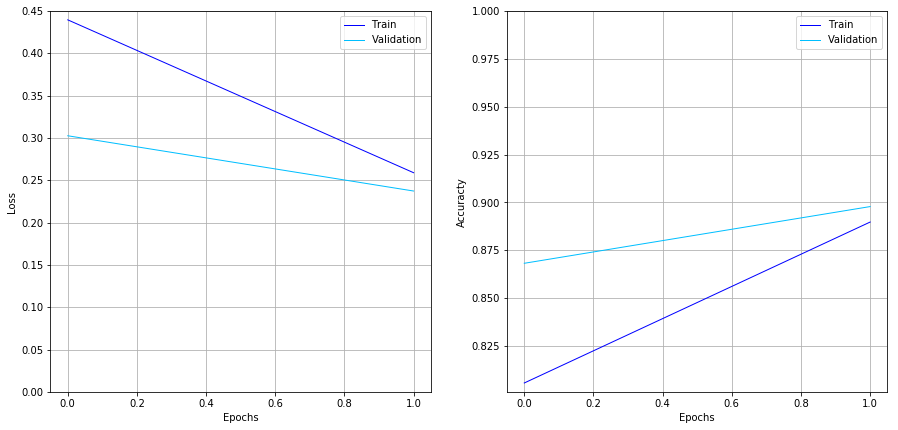

Train Accuracy of last epoch:  0.8897819387439849
Validation Accuracy of last epoch:  0.8978687074878121
Train Loss of last epoch:  0.25895418105315565
Validation Loss of last epoch:  0.23732129330443494
Epoch 3/250
2932736/4982178 [================>.............] - ETA: 21s - loss: 0.2160 - acc: 0.9088

KeyboardInterrupt: 

In [4]:
fitHistory, logDir = trainModel(resID, model)

score = calcScore(model)

saveTrainResults(resID, model, logDir)
# compareResults('005','013', metric1='acc', metric2='acc', saveFigName = 'testmynd', makeEqual = True)

# Experiment 
test different net depth


In [2]:
##############################
#    PARAMETERS 
##############################
import math

# Experiment description
expDescr = "Testing 7 CNN layeres"

# What data to use
tableBase = '4PpKk'
convertStates = False
fractionOfDataToUse = 1 # [0,1]

# Interactive (just in general if one is asked for confirmations, set to False if on autopilot over night f.x.)
askForConfirmation = False

# Transfer Learning
loadWeights = False 
weightsSource = '024'

# Compare with other result during training
compareResultsDuringTraining = False
compareWith = '013' # orginal net structure, trained from random on 4pc dataset


# NN parameters
# filters = [8,16,16,32,32]    #016:0.913  10kpm 2048:30                  8192:23:38% 32768:17:52% 
# filters = [8,16,32,64,128]   #005:0.952  50kpm 2048:37s    4096:28:50% 
# filters = [8,32,64,128,256]  #013:0.968 188kpm 2048:50s    4096:40s:61%             32768:46s:80% 65536:42s:99% 
# filters = [32,64,128,160,256]#014:0.974 388kpm 2048:3m:91% 
filters = [16,32,64,128,128,128] #035:0.975 191kpm 2048:45s:50%/50% 2048:68s:78% 
filterShape = [2,2,2,2,2,2]
batch_size = 2048
epochs = 250
multiGPU = False
whichGPU = 0
# optimizer = 'Adam'
optimizer = 'Adadelta'
useBatchNorm = False

# Other paramters
confirmDirOverwrite = False

### NO NEED TO MODIFY BELOW ###
# Generate dataset variables
fileName = tableBase + '.hdf5'
dataSetName = tableBase + '_onlyLegal'
if not convertStates: 
    dataSetName = tableBase + '_onlyLegal_fullState'
dataSetWdlName = tableBase + '_Wdl_onlyLegal'

# Number of Pieces
nPi =  int(dataSetName[0])
nPa = nPi - 2
nWPa = math.ceil(nPa/2)

# Select which GPU to use
if(multiGPU):
    from keras.utils.training_utils import multi_gpu_model
else:
    import os
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
    # The GPU id to use, usually either "0" or "1"
    os.environ["CUDA_VISIBLE_DEVICES"] = str(whichGPU)
    
# Other NN stuff
num_classes = 5
input_shape = (4,8,8)


In [3]:
model, nnStr = createModel()
resID = genNextResultsDir(model)
X_train, X_test, y_train, y_test = loadData()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 7, 7)          272       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 6, 32)         928       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 5, 64)         8256      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 4, 128)        32896     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 12, 3, 128)        65664     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 11, 2, 128)        65664     
_________________________________________________________________
flatten_1 (Flatten)          (None, 2816)              0         
__________

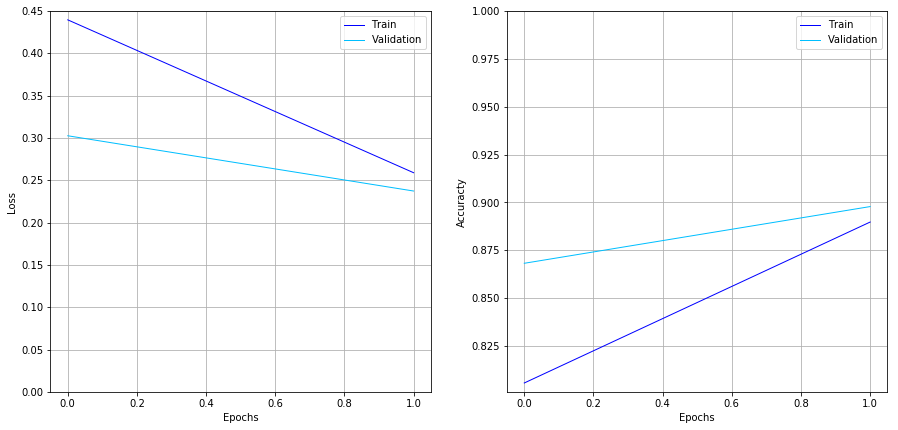

Train Accuracy of last epoch:  0.8897819387439849
Validation Accuracy of last epoch:  0.8978687074878121
Train Loss of last epoch:  0.25895418105315565
Validation Loss of last epoch:  0.23732129330443494
Epoch 3/250
2932736/4982178 [================>.............] - ETA: 21s - loss: 0.2160 - acc: 0.9088

KeyboardInterrupt: 

In [4]:
fitHistory, logDir = trainModel(resID, model)

score = calcScore(model)

saveTrainResults(resID, model, logDir)
# compareResults('005','013', metric1='acc', metric2='acc', saveFigName = 'testmynd', makeEqual = True)